<a href="https://colab.research.google.com/github/pythagoras58/qip_convex_hull_QSC/blob/main/phase_estimation_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U qiskit
!pip install qiskit-aer
!pip install pylatexenc
!pip install pdflatex

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_state_qsphere, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:

def phase_estimation_circuit(x_i, x_j, num_ancilla=8):
    if x_i == x_j:
        normalized_diff = 0.0
    else:
        max_val = max(abs(x_i), abs(x_j))
        normalized_diff = (x_i - x_j) / max_val

    phase_angle = 2 * np.pi * normalized_diff

    ancilla_register = QuantumRegister(num_ancilla, 'ancilla')
    input_register = QuantumRegister(1, 'input')
    classical_register = ClassicalRegister(num_ancilla, 'c')
    circuit = QuantumCircuit(ancilla_register, input_register, classical_register)

    circuit.h(ancilla_register)
    circuit.h(input_register)  # Superposition on input

    for i in range(num_ancilla):
        circuit.cp(phase_angle * (2**i), ancilla_register[i], input_register[0])

    circuit.h(input_register) # Reset input qubit

    qft_dagger = QFT(num_ancilla, do_swaps=False).inverse()
    circuit.append(qft_dagger, ancilla_register)

    circuit.measure(ancilla_register, classical_register)

    # visualization
    circuit.draw('mpl')
    plt.show()


    return circuit, normalized_diff

# def simulate_phase_estimation(x_i, x_j, num_shots=2048):  # Increased shots for better statistics
#     num_ancilla = 8
#     circuit, normalized_diff = phase_estimation_circuit(x_i, x_j, num_ancilla)

#     simulator = AerSimulator()
#     transpiled_circuit = transpile(circuit, simulator)
#     result = simulator.run(transpiled_circuit, shots=num_shots).result()
#     counts = result.get_counts()

#     phases = []
#     for outcome, count in counts.items():
#         phase = int(outcome, 2) / (2**num_ancilla)
#         phases.extend([phase] * count)  # Add each phase according to its count

#     # Maximum Likelihood Estimation (MLE) - approximating with normal dist.
#     mu, sigma = norm.fit(phases)  # Fit a normal distribution to the phases

#     estimated_phase = mu # Use the mean of the fitted normal distribution

#     tolerance = 0.1  # Adjust tolerance as needed (increased slightly)

#     if abs(normalized_diff) < tolerance and abs(estimated_phase - 0.5) < tolerance:
#         comparison_result = "x_i == x_j"
#     elif normalized_diff > 0 and estimated_phase > 0.5 + tolerance/2:
#         comparison_result = "x_i > x_j"
#     elif normalized_diff < 0 and estimated_phase < 0.5 - tolerance/2:
#         comparison_result = "x_i < x_j"
#     else:
#         comparison_result = "Inconclusive"
#         print(f"Warning! Inconclusive. Normalized Diff: {normalized_diff}, Estimated Phase: {estimated_phase}, Sigma: {sigma}")  # Include sigma in the output

#     return comparison_result, counts



In [ ]:
def simulate_phase_estimation(x_i, x_j, num_shots=2048):
    num_ancilla = 8
    circuit, normalized_diff = phase_estimation_circuit(x_i, x_j, num_ancilla)

    # Get statevector before measurement
    # state = Statevector.from_instruction(circuit)
    # Get the statevector before measurement
    statevector = Statevector(circuit.remove_final_measurements(inplace=False))

    simulator = AerSimulator()
    transpiled_circuit = transpile(circuit, simulator)
    result = simulator.run(transpiled_circuit, shots=num_shots).result()
    counts = result.get_counts()

    phases = []
    for outcome, count in counts.items():
        phase = int(outcome, 2) / (2**num_ancilla)
        phases.extend([phase] * count)

    mu, sigma = norm.fit(phases)

    estimated_phase = mu
    tolerance = 0.1

    if abs(normalized_diff) < tolerance and abs(estimated_phase - 0.5) < tolerance:
        comparison_result = "x_i == x_j"
    elif normalized_diff > 0 and estimated_phase > 0.5 + tolerance / 2:
        comparison_result = "x_i > x_j"
    elif normalized_diff < 0 and estimated_phase < 0.5 - tolerance / 2:
        comparison_result = "x_i < x_j"
    else:
        comparison_result = "Inconclusive"
        print(f"Warning! Inconclusive. Normalized Diff: {normalized_diff}, Estimated Phase: {estimated_phase}, Sigma: {sigma}")

    return comparison_result, counts, circuit, statevector  # Added circuit to return values

In [ ]:
def plot_phase_distribution(counts, num_ancilla):
    phases = [int(outcome, 2) / (2 ** num_ancilla) for outcome in counts.keys()]
    probabilities = np.array(list(counts.values())) / sum(counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(phases, probabilities, width=0.01, color='b', alpha=0.7, label="Measured Phases")

    mu, sigma = norm.fit(phases, floc=0)
    x_vals = np.linspace(min(phases), max(phases), 100)
    plt.plot(x_vals, norm.pdf(x_vals, mu, sigma), 'r-', label="Fitted Normal Distribution")

    plt.xlabel("Estimated Phase")
    plt.ylabel("Probability")
    plt.title("Phase Estimation Probability Distribution")
    plt.legend()
    plt.show()

def plot_bloch_sphere(circuit):
    state = Statevector.from_instruction(circuit)
    bloch_vector = state.data[:3]
    plot_bloch_vector(bloch_vector, title="Bloch Sphere Representation of Input Qubit")

In [ ]:
# Test Cases
test_cases = [
    (5, 3, "x_i > x_j"),
    (2, 2, "x_i == x_j"),
    (1, 4, "x_i < x_j"),
    (-1, 1, "x_i < x_j"),
    (0, -2, "x_i > x_j"),
    (0.5, 0.51, "x_i < x_j"),
    (0.5, 0.49, "x_i > x_j"),
    (1.0, 1.0 + 1e-7, "x_i == x_j"),
    (1.0, 1.0 + 0.1, "x_i < x_j"),
    (1.0, 1.0 - 0.1, "x_i > x_j")
]

# for x_i, x_j, expected_result in test_cases:
#     result, counts = simulate_phase_estimation(x_i, x_j)
#     print(f"x_i: {x_i}, x_j: {x_j}")
#     print(f"Result: {result}")
#     print(f"Counts: {counts}")
#     print(f"Expected: {expected_result}")
#     print("-" * 20)
for x_i, x_j, expected_result in test_cases:
    result, counts, circuit, statevector = simulate_phase_estimation(x_i, x_j)  # Expect 3 values now
    print(f"x_i: {x_i}, x_j: {x_j}")
    print(f"Result: {result}")
    print(f"Counts: {counts}")
    print(f"Expected: {expected_result}")
    print("-" * 20)

Warning! Inconclusive. Normalized Diff: 0.4, Estimated Phase: 0.1829833984375, Sigma: 0.25688371105227786
x_i: 5, x_j: 3
Result: Inconclusive
Counts: {'10100011': 3, '01101000': 1, '01011111': 2, '01100101': 2, '00100100': 2, '11110111': 12, '00101100': 1, '00110101': 6, '11111111': 3, '01010111': 1, '00101101': 1, '11100110': 1, '01100100': 8, '01000111': 49, '11000100': 1, '01001111': 9, '11110011': 60, '00000100': 1, '00100111': 45, '11000111': 2, '00100101': 5, '11000011': 4, '00110000': 1, '10000101': 1, '11101111': 17, '11110100': 5, '11011111': 1, '00110111': 45, '00110010': 2, '11101110': 1, '00000000': 1021, '00101111': 88, '01000011': 82, '11100011': 18, '01100111': 47, '00110011': 228, '01101111': 40, '00110100': 22, '11100111': 20, '00110110': 5, '00100011': 21, '01110011': 57, '11100100': 6, '01100011': 52, '11001111': 1, '11001100': 1, '00100110': 4, '00001111': 1, '10000011': 2, '01100110': 3, '01000100': 8, '00000011': 3, '01110111': 4, '01110110': 1, '01101011': 2, '00

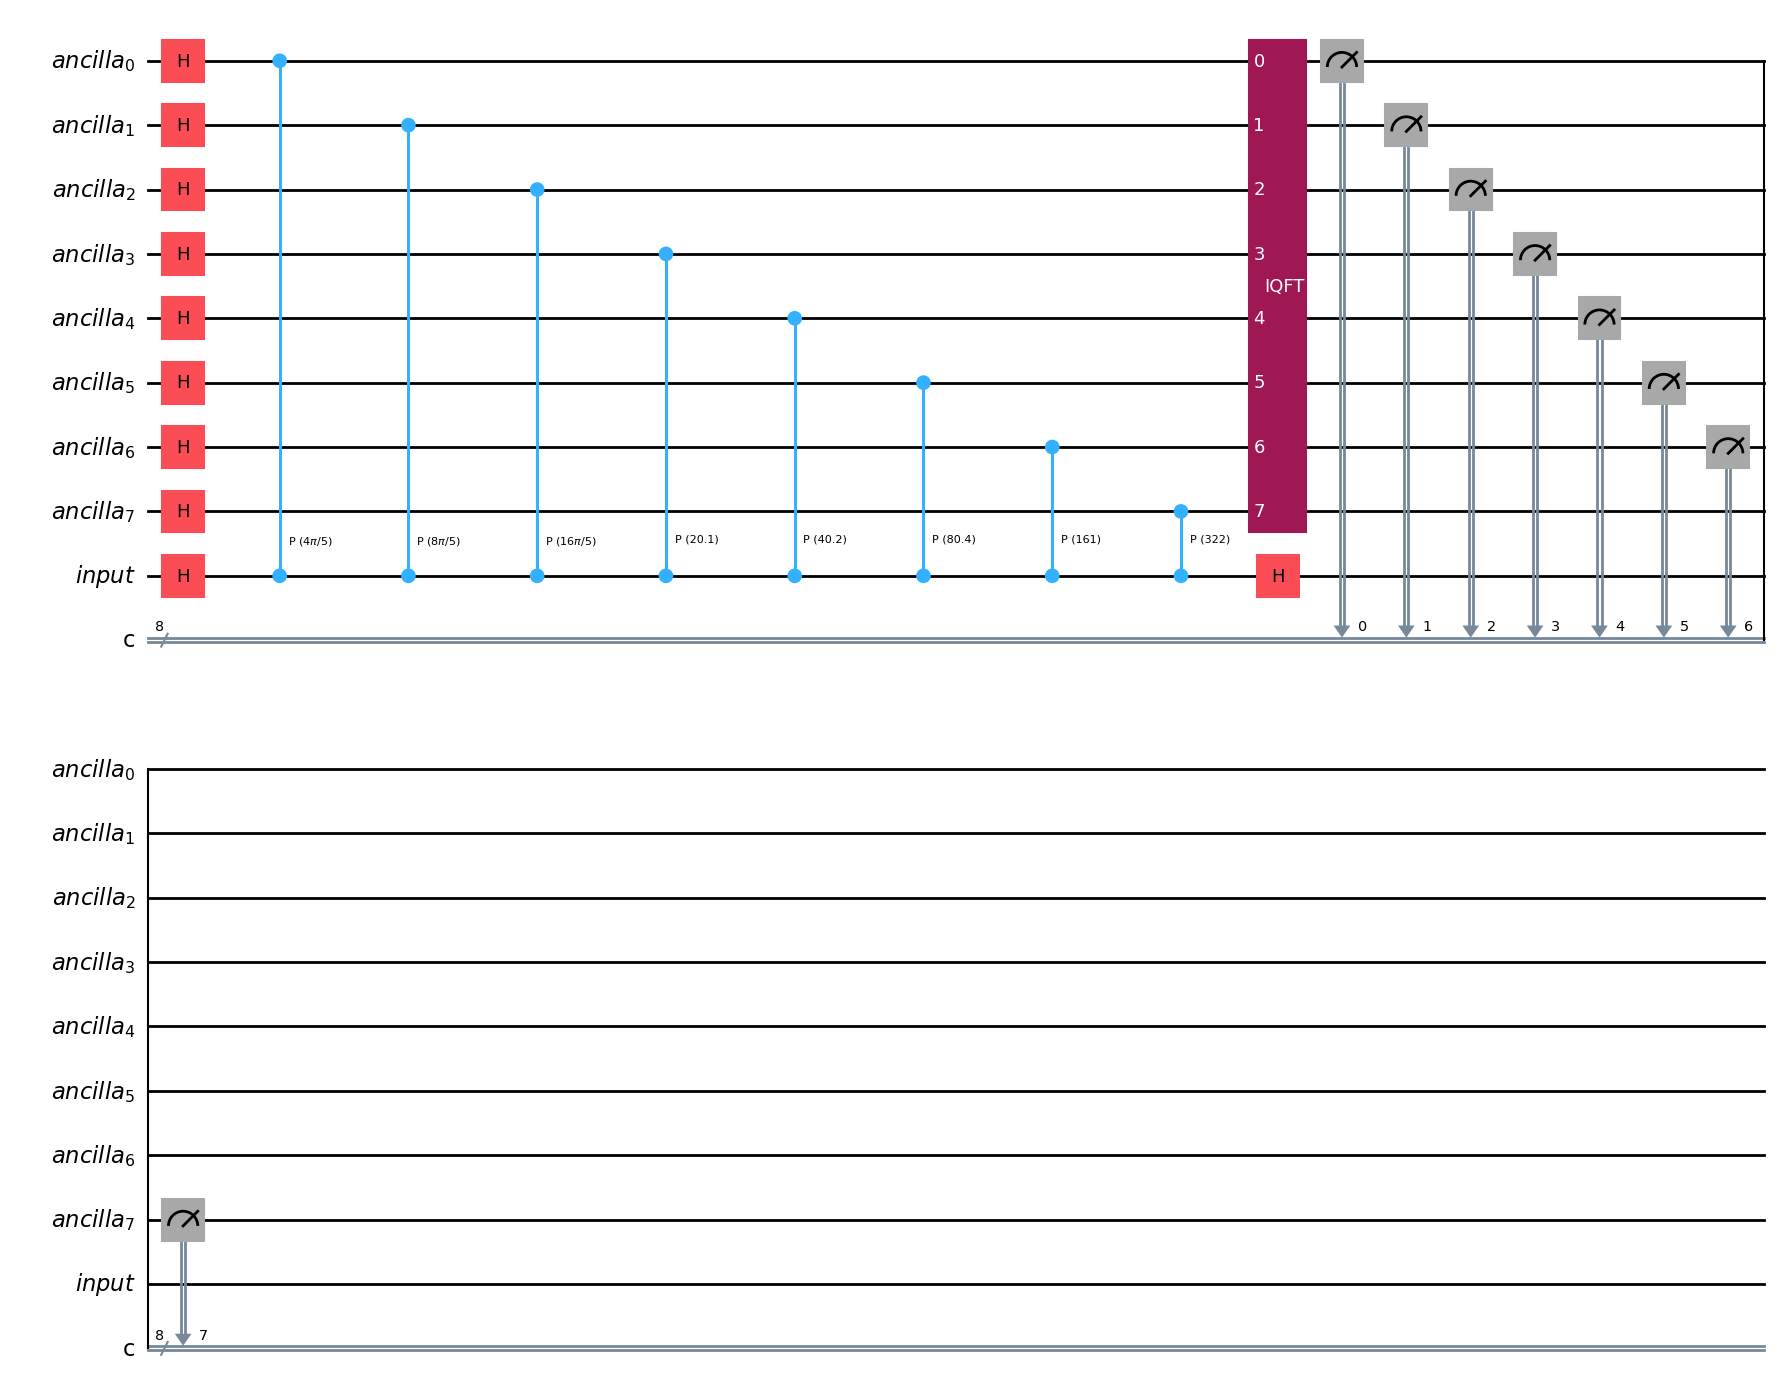

In [ ]:
# Test Visualization
circuit, _ = phase_estimation_circuit(5, 3)
circuit.draw('mpl')

In [ ]:
circuit.depth()

11

Warning! Inconclusive. Normalized Diff: 0.4, Estimated Phase: 0.18287277221679688, Sigma: 0.25929861081968225


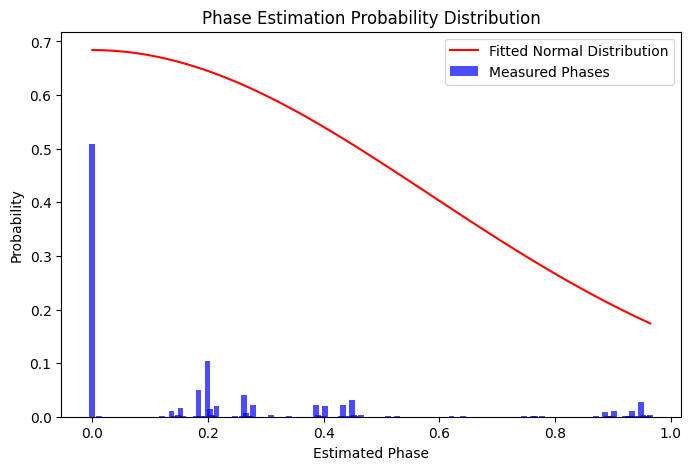

In [ ]:
# Run a test case with visualization
x_i, x_j = 5, 3
result, counts, circuit, statevector = simulate_phase_estimation(x_i, x_j)

# Visualize the phase estimation probability distribution
plot_phase_distribution(counts, num_ancilla=8)



In [ ]:
# Visualize the Bloch sphere representation of the input qubit
plot_bloch_sphere(circuit)


QiskitError: 'Cannot apply instruction with classical bits: measure'

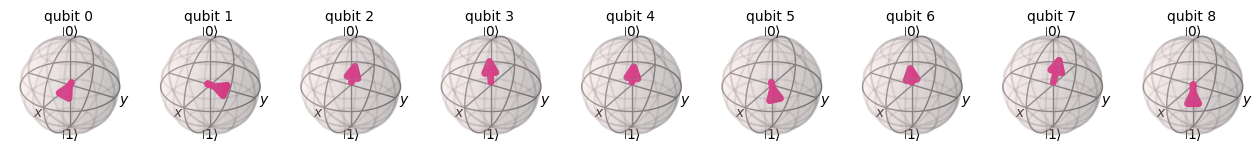

In [ ]:
# Plot Bloch sphere representation
plot_bloch_multivector(statevector)